# Trabalho Final - Machine Learning

* integrante 1
* integrante 2
* integrante 3
* integrante 4

Neste trabalho, como parte do time de analistas da Quantum Finance, vocês deverão explorar uma base de dados originalmente utilizada para classificação de score de crédito, disponível no Kaggle (https://www.kaggle.com/datasets/parisrohan/credit-score-classification), utilizando técnicas de Análise Exploratória de Dados (EDA) e algoritmos de Machine Learning supervisionados. 


O objetivo é aplicar e interpretar os resultados obtidos, assim como criar um sistema que gere valor a partir da análise da base de dados.

**Modelo de Classificação Supervisionada**


Desenvolver um modelo de classificação supervisionada para prever a classificação de crédito dos indivíduos presentes na base.


Passos esperados:

1. Realizar uma análise exploratória dos dados (EDA) para entender as características principais da base e as relações entre variáveis; 2 pontos

2. Implementar um pipeline de modelo de classificação usando Random Forest, XGBoost e LightGBM. Use GridSearch para otimizar os parametros de cada modelo; 4 pontos

3. Avaliar os resultados utilizando a métrica mais adequada e **justifique** sua escolha; 2 pontos

4. Apresentar os resultados, indicando a métrica no conjunto de treino (train.csv) e explicar como o modelo pode ser utilizado para decisões financeiras. 2 pontos


Entregáveis:

1. Este jupyter notebook executado e com os resultados aparentes (não serão aceitos outros formatos)

### 1. Importação de Bibliotecas

Importa as principais bibliotecas para análise de dados, visualização e machine learning:

pandas, numpy: manipulação de dados

seaborn, matplotlib: gráficos

sklearn: modelos, pré-processamento e validação

xgboost, lightgbm: algoritmos de ML avançados

In [42]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from pandas import DataFrame

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




### 2. Carregamento dos Dados

Carrega o arquivo de dados principal para um DataFrame.

In [43]:
df_original = pd.read_csv("train.csv")  


In [44]:
df_original.describe().round(2)  # proporção de valores ausentes por coluna

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.00,100000.00,100000.00,100000.00,100000.00,98035.00,100000.00,100000.00
mean,4194.17,17.09,22.47,72.47,21.07,27.75,32.29,1403.12
std,3183.69,117.40,129.06,466.42,14.86,193.18,5.12,8306.04
min,303.65,-1.00,0.00,1.00,-5.00,0.00,20.00,0.00
25%,1625.57,3.00,4.00,8.00,10.00,3.00,28.05,30.31
50%,3093.75,6.00,5.00,13.00,18.00,6.00,32.31,69.25
75%,5957.45,7.00,7.00,20.00,28.00,9.00,36.50,161.22
max,15204.63,1798.00,1499.00,5797.00,67.00,2597.00,50.00,82331.00


In [45]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob


<i><p style='color:#006DB2' ><big><strong>3.</strong></big> Tratamento de Dados </p>
<p style='color:#006DB2' >Converte colunas para tipos numéricos e trata valores inconsistentes:</p>
<p style='color:#006DB2' >
Usa pd.to_numeric(..., errors='coerce') para garantir que os dados estejam no formato correto.
Mapeia variáveis categóricas para valores numéricos (ex: Credit_Score, Credit_Mix, Payment_of_Min_Amount). </p></i>

In [46]:
df_dados_numericos_tratados = df_original.copy()

df_dados_numericos_tratados['Outstanding_Debt'] = pd.to_numeric(df_original['Outstanding_Debt'], errors='coerce').astype(float)
df_dados_numericos_tratados['Changed_Credit_Limit'] = pd.to_numeric(df_original['Changed_Credit_Limit'], errors='coerce').astype(float)
df_dados_numericos_tratados['Num_of_Loan'] = pd.to_numeric(df_original['Num_of_Loan'], errors='coerce').astype(float)
df_dados_numericos_tratados['Annual_Income'] = pd.to_numeric(df_original['Annual_Income'], errors='coerce').astype(float)
df_dados_numericos_tratados['Monthly_Balance'] = pd.to_numeric(df_original['Monthly_Balance'], errors='coerce').astype(float)
df_dados_numericos_tratados['Amount_invested_monthly'] = pd.to_numeric(df_original['Amount_invested_monthly'], errors='coerce').astype(float)
df_dados_numericos_tratados['Monthly_Inhand_Salary'] = pd.to_numeric(df_original['Monthly_Inhand_Salary'], errors='coerce').astype(float)
df_dados_numericos_tratados['Num_of_Delayed_Payment'] = pd.to_numeric(df_original['Num_of_Delayed_Payment'], errors='coerce').astype(float)

score_map = {'Poor': 0, 'Standard': 1, 'Good': 2}
df_dados_numericos_tratados['Credit_Score'] = df_original['Credit_Score'].map(score_map).astype('Int64')

score_map2 = {'Bad': 0, 'Standard': 1, 'Good': 2, '_': None}
df_dados_numericos_tratados['Credit_Mix'] = df_original['Credit_Mix'].map(score_map2).astype('Int64')

score_map3 = {'NM': 0, 'No': 1, 'Yes': 2}
df_dados_numericos_tratados['Payment_of_Min_Amount'] = df_original['Payment_of_Min_Amount'].map(score_map3).astype('Int64')

<i><p style='color:#006DB2' ><big><strong>4.</strong></big> Limpeza de Colunas Específicas </p>
<p style='color:#006DB2' >Remove caracteres indesejados e converte para numérico:</p>
<p style='color:#006DB2' >Age e Credit_History_Age passam por limpeza de strings e conversão para números. </p></i>

In [47]:
df_dados_numericos_tratados['Age'] = (
    df_dados_numericos_tratados['Age']
    .astype(str)
    .str.replace('-', '', regex=False)
    .str.replace(' ', '', regex=False)  
    .str.replace('_', '', regex=False) 
    .str.replace('nan', '', regex=False)  
    .str.strip()
)

df_dados_numericos_tratados['Age'] = pd.to_numeric(df_dados_numericos_tratados['Age'], errors='coerce').astype(int)

df_dados_numericos_tratados['Credit_History_Age'] = (
    df_dados_numericos_tratados['Credit_History_Age']
    .astype(str)
    .str.replace(' Years and ', '.', regex=False)
    .str.replace(' Months', '', regex=False) 
    .str.replace(' ', '', regex=False) 
    .str.replace('nan', '', regex=False) 
    .str.strip()
)

df_dados_numericos_tratados['Credit_History_Age'] = pd.to_numeric(df_dados_numericos_tratados['Credit_History_Age'], errors='coerce').astype(float)


Estatísticas da coluna Age:
count    100000.000000
mean        119.509700
std         684.757313
min          14.000000
25%          25.000000
50%          34.000000
75%          42.000000
max        8698.000000
Name: Age, dtype: float64

Distribuição dos valores de Age:
Age
8698       1
8697       1
8682       1
8678       1
8674       1
        ... 
18      2385
17      1502
16      1455
15      1574
14      1175
Name: count, Length: 1728, dtype: int64


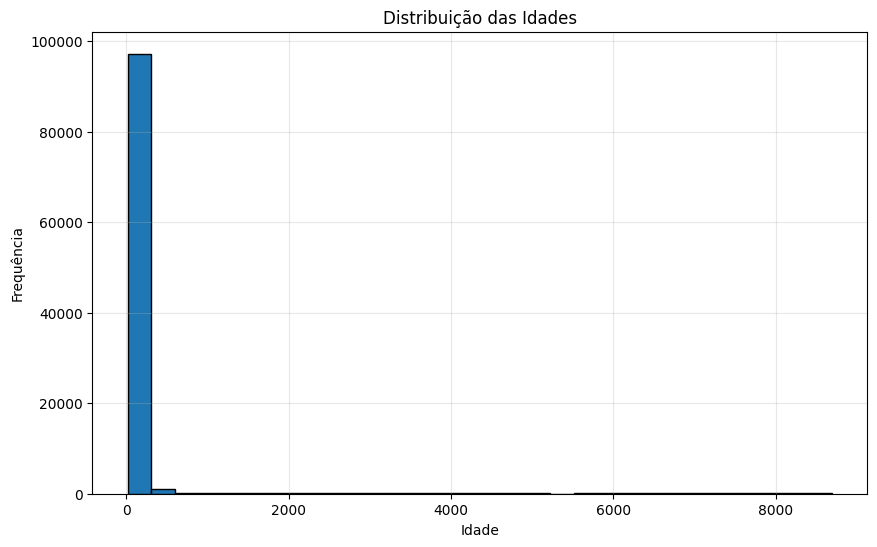


Distribuição por faixa etária:
Faixa_Etaria
0-20     13628
21-30    27964
31-40    28144
41-50    20443
51-60     7040
61-70        0
71-80        0
81-90        0
90+       2781
Name: count, dtype: int64

Estatísticas para idade até 60 anos:
Média de idade: 33.32
Mediana de idade: 33.00


In [ ]:
# Análise da coluna Age
print("\nEstatísticas da coluna Age:")
print(df_dados_numericos_tratados['Age'].describe())

# Verificar valores únicos e suas contagens
print("\nDistribuição dos valores de Age:")
print(df_dados_numericos_tratados['Age'].value_counts().sort_index(ascending=False))

# Plotar histograma da distribuição de idades
plt.figure(figsize=(10,6))
plt.hist(df_dados_numericos_tratados['Age'], bins=30, edgecolor='black')
plt.title('Distribuição das Idades')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)
plt.show()

# Análise por faixa etária
faixas_etarias = [0, 20, 30, 40, 50, 60, 70, 80, 90, float('inf')]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '90+']
df_dados_numericos_tratados['Faixa_Etaria'] = pd.cut(df_dados_numericos_tratados['Age'], bins=faixas_etarias, labels=labels, right=True)

print("\nDistribuição por faixa etária:")
print(df_dados_numericos_tratados['Faixa_Etaria'].value_counts().sort_index())



In [55]:
# Filtrando dados para idade até 60 anos
dados_ate_60 = df_dados_numericos_tratados[df_dados_numericos_tratados['Age'] <= 60]

print("\nEstatísticas para idade até 60 anos:")
print(f"Média de idade: {dados_ate_60['Age'].mean():.2f}")
print(f"Mediana de idade: {dados_ate_60['Age'].median():.2f}")

# Criando novo dataframe com base no df_dados_numericos_tratados
df_age_tratados = df_dados_numericos_tratados.copy()

# Obtendo a mediana calculada anteriormente para idades até 60 anos
mediana_ate_60 = dados_ate_60['Age'].median()

# Substituindo valores de Age maiores que 60 pela mediana
df_age_tratados.loc[df_age_tratados['Age'] > 60, 'Age'] = mediana_ate_60

print("\nEstatísticas da coluna Age após tratamento:")
print(df_age_tratados['Age'].describe())



Estatísticas para idade até 60 anos:
Média de idade: 33.32
Mediana de idade: 33.00

Estatísticas da coluna Age após tratamento:
count    100000.00000
mean         33.31111
std          10.61888
min          14.00000
25%          25.00000
50%          33.00000
75%          41.00000
max          56.00000
Name: Age, dtype: float64


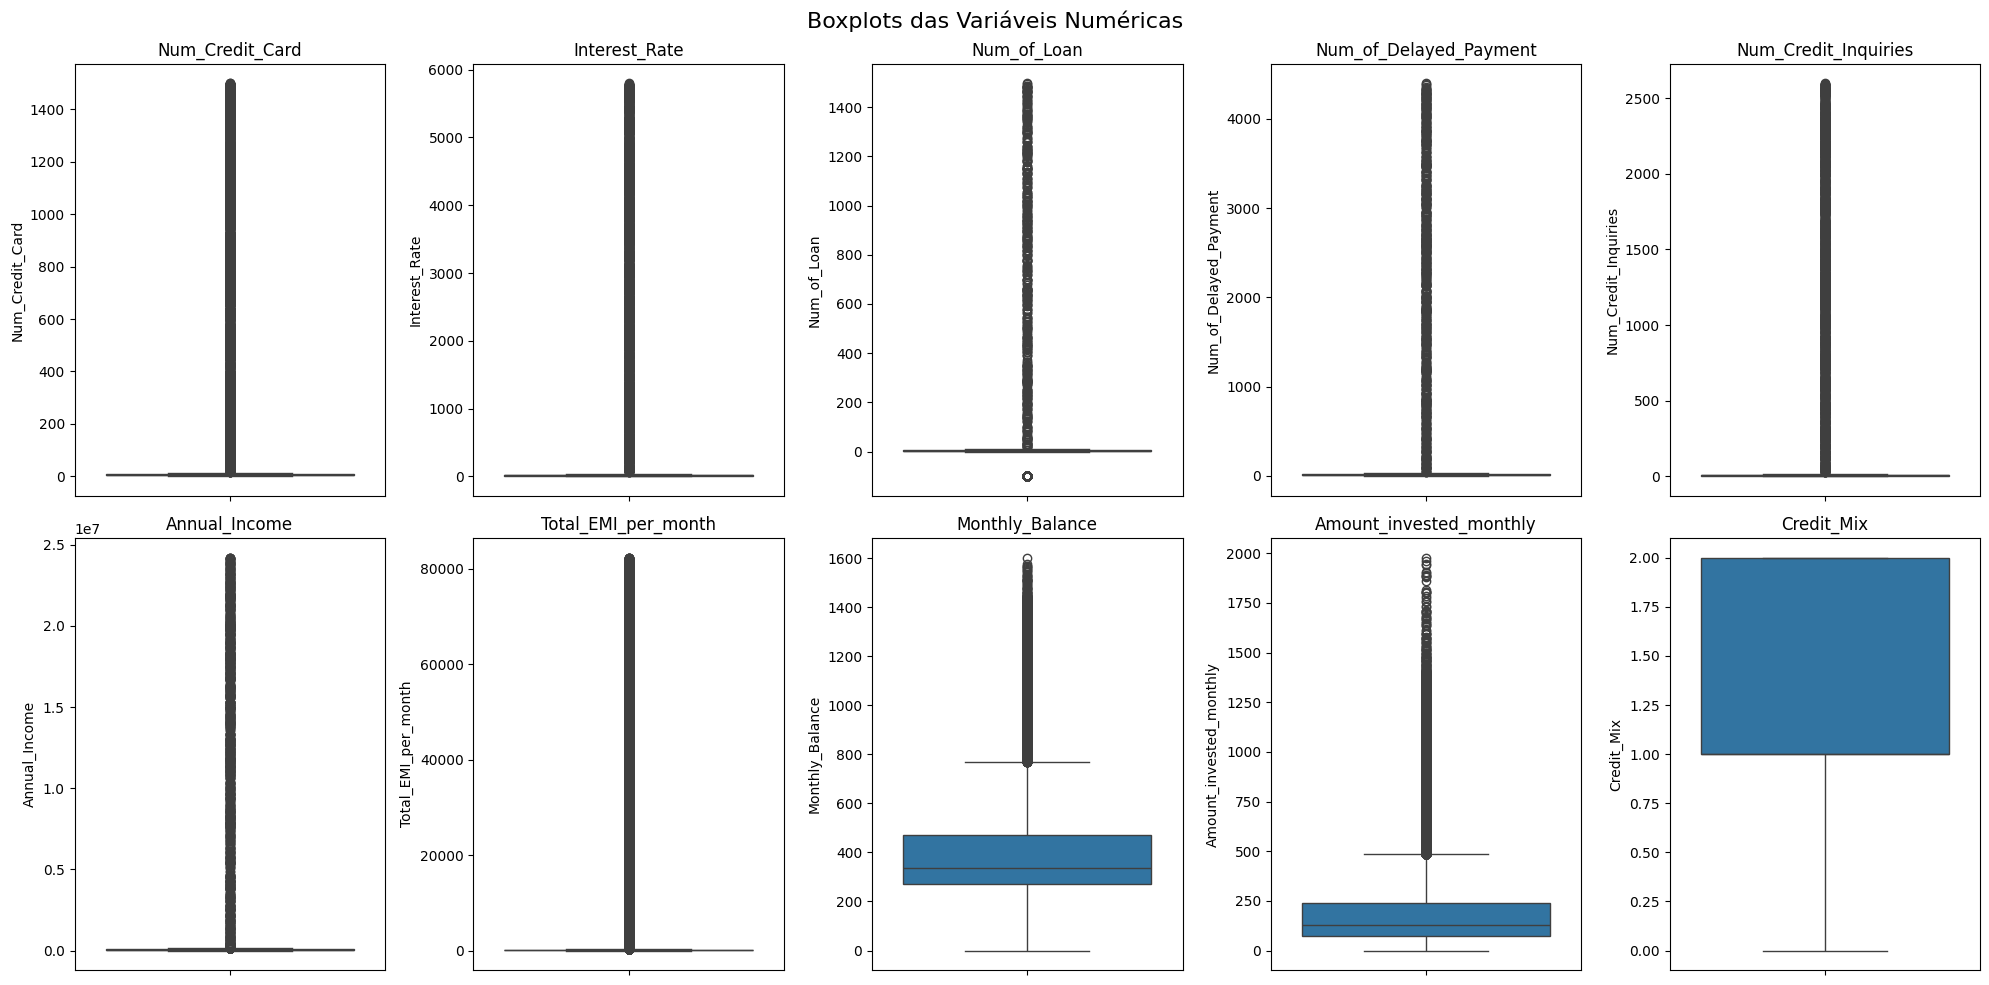

In [56]:
# Criando subplots para os boxplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Boxplots das Variáveis Numéricas', fontsize=16)

# Lista de colunas para plotar
colunas = ['Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment', 
           'Num_Credit_Inquiries', 'Annual_Income', 'Total_EMI_per_month', 'Monthly_Balance',
           'Amount_invested_monthly', 'Credit_Mix']

# Plotando cada boxplot
for i, coluna in enumerate(colunas):
    row = i // 5
    col = i % 5
    sns.boxplot(data=df_age_tratados, y=coluna, ax=axes[row, col])
    axes[row, col].set_title(coluna)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [59]:
# Análise da coluna Num_Credit_Card
print("Estatísticas descritivas da coluna Num_Credit_Card:")
print(df_age_tratados['Num_Credit_Card'].describe())

# Calculando os limites para outliers usando o método IQR
Q1 = df_age_tratados['Num_Credit_Card'].quantile(0.25)
Q3 = df_age_tratados['Num_Credit_Card'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print("\nLimites para outliers:")
print(f"Limite inferior: {limite_inferior:.2f}")
print(f"Limite superior: {limite_superior:.2f}")

# Identificando outliers
outliers = df_age_tratados[(df_age_tratados['Num_Credit_Card'] < limite_inferior) | 
                          (df_age_tratados['Num_Credit_Card'] > limite_superior)]

print("\nQuantidade de outliers:", len(outliers))
print(f"Percentual de outliers: {(len(outliers)/len(df_age_tratados))*100:.2f}%")

# Análise por faixa de score de crédito
print("\nMédia de cartões de crédito por score:")
print(df_age_tratados.groupby('Credit_Score')['Num_Credit_Card'].mean())


# Com base na análise anterior, podemos ver que há uma correlação negativa (-0.399)
# entre Num_Credit_Card e Credit_Score, sugerindo que um número muito alto de cartões
# pode impactar negativamente o score de crédito. 


# Criando dataframe temporário apenas com registros dentro dos limites
df_temp = df_age_tratados[(df_age_tratados['Num_Credit_Card'] >= limite_inferior) & 
                         (df_age_tratados['Num_Credit_Card'] <= limite_superior)]

print("\nEstatísticas dos registros dentro dos limites:")
print(f"Média de cartões de crédito: {df_temp['Num_Credit_Card'].mean():.2f}")
print(f"Mediana de cartões de crédito: {df_temp['Num_Credit_Card'].median():.2f}")

# Criando novo dataframe com os valores ajustados
df_num_credit_card_tratados = df_age_tratados.copy()

# Obtendo a mediana dos registros dentro dos limites
mediana_cartoes = df_temp['Num_Credit_Card'].median()

# Ajustando valores fora dos limites para a mediana
df_num_credit_card_tratados.loc[df_num_credit_card_tratados['Num_Credit_Card'] < limite_inferior, 'Num_Credit_Card'] = mediana_cartoes
df_num_credit_card_tratados.loc[df_num_credit_card_tratados['Num_Credit_Card'] > limite_superior, 'Num_Credit_Card'] = mediana_cartoes

print("\nEstatísticas após o tratamento dos outliers:")
print(df_num_credit_card_tratados['Num_Credit_Card'].describe())



Estatísticas descritivas da coluna Num_Credit_Card:
count    100000.00000
mean         22.47443
std         129.05741
min           0.00000
25%           4.00000
50%           5.00000
75%           7.00000
max        1499.00000
Name: Num_Credit_Card, dtype: float64

Limites para outliers:
Limite inferior: -0.50
Limite superior: 11.50

Quantidade de outliers: 2271
Percentual de outliers: 2.27%

Média de cartões de crédito por score:
Credit_Score
0    23.981447
1    22.079926
2    21.199854
Name: Num_Credit_Card, dtype: float64

Estatísticas dos registros dentro dos limites:
Média de cartões de crédito: 5.53
Mediana de cartões de crédito: 5.00

Estatísticas após o tratamento dos outliers:
count    100000.000000
mean          5.521210
std           2.045632
min           0.000000
25%           4.000000
50%           5.000000
75%           7.000000
max          11.000000
Name: Num_Credit_Card, dtype: float64


In [ ]:
# Substituindo valores negativos de Num_Bank_Accounts por 0
df_num_credit_card_tratados.loc[df_num_credit_card_tratados['Num_Bank_Accounts'] < 0, 'Num_Bank_Accounts'] = 0

print("\nEstatísticas após substituir valores negativos:")
print(df_num_credit_card_tratados['Num_Bank_Accounts'].describe())

# Análise de outliers para Num_Bank_Accounts
Q1 = df_num_credit_card_tratados['Num_Bank_Accounts'].quantile(0.25)
Q3 = df_num_credit_card_tratados['Num_Bank_Accounts'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print("\nLimites para outliers:")
print(f"Limite inferior: {limite_inferior:.2f}")
print(f"Limite superior: {limite_superior:.2f}")

# Identificando outliers
outliers = df_num_credit_card_tratados[(df_num_credit_card_tratados['Num_Bank_Accounts'] < limite_inferior) | 
                                     (df_num_credit_card_tratados['Num_Bank_Accounts'] > limite_superior)]

print("\nQuantidade de outliers:", len(outliers))
print(f"Percentual de outliers: {(len(outliers)/len(df_num_credit_card_tratados))*100:.2f}%")

# Análise por faixa de score de crédito
print("\nMédia de contas bancárias por score:")
print(df_num_credit_card_tratados.groupby('Credit_Score')['Num_Bank_Accounts'].mean())

# Com base na análise anterior, podemos ver que há uma correlação negativa (-0.390)
# entre Num_Bank_Accounts e Credit_Score, sugerindo que um número muito alto de contas
# pode impactar negativamente o score de crédito.

# Criando dataframe temporário apenas com registros dentro dos limites
df_temp = df_num_credit_card_tratados[(df_num_credit_card_tratados['Num_Bank_Accounts'] >= limite_inferior) & 
                                    (df_num_credit_card_tratados['Num_Bank_Accounts'] <= limite_superior)]

print("\nEstatísticas dos registros dentro dos limites:")
print(f"Média de contas bancárias: {df_temp['Num_Bank_Accounts'].mean():.2f}")
print(f"Mediana de contas bancárias: {df_temp['Num_Bank_Accounts'].median():.2f}")

# Criando novo dataframe com os valores ajustados
df_num_bank_accounts_tratados = df_num_credit_card_tratados.copy()

# Obtendo a mediana dos registros dentro dos limites
mediana_contas = df_temp['Num_Bank_Accounts'].median()

# Ajustando valores fora dos limites para a mediana
df_num_bank_accounts_tratados.loc[df_num_bank_accounts_tratados['Num_Bank_Accounts'] < limite_inferior, 'Num_Bank_Accounts'] = mediana_contas
df_num_bank_accounts_tratados.loc[df_num_bank_accounts_tratados['Num_Bank_Accounts'] > limite_superior, 'Num_Bank_Accounts'] = mediana_contas

print("\nEstatísticas após o tratamento dos outliers:")
print(df_num_bank_accounts_tratados['Num_Bank_Accounts'].describe())



Estatísticas após substituir valores negativos:
count    100000.000000
mean         17.091490
std         117.404803
min           0.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: Num_Bank_Accounts, dtype: float64

Limites para outliers:
Limite inferior: -3.00
Limite superior: 13.00

Quantidade de outliers: 1315
Percentual de outliers: 1.31%

Média de contas bancárias por score:
Credit_Score
0    18.724705
1    16.873867
2    15.084081
Name: Num_Bank_Accounts, dtype: float64

Estatísticas dos registros dentro dos limites:
Média de contas bancárias: 5.37
Mediana de contas bancárias: 5.00

Estatísticas após o tratamento dos outliers:
count    100000.00000
mean          5.36300
std           2.57659
min           0.00000
25%           3.00000
50%           5.00000
75%           7.00000
max          11.00000
Name: Num_Bank_Accounts, dtype: float64


<i><p style='color:#006DB2' ><big><strong>5.</strong></big> Função para Remoção de Outliers </p>
<p style='color:#006DB2' >Remove outliers de colunas numéricas usando o método do IQR.</p></i>

In [7]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

<i><p style='color:#006DB2' ><big><strong>6.</strong></big>Aplicação da Remoção de Outliers</p>
<p style='color:#006DB2' >Aplica a função para várias colunas relevantes do DataFrame.</p></i>

In [ ]:
# df = remove_outliers_iqr(df, 'Interest_Rate')
# df = remove_outliers_iqr(df, 'Num_of_Loan')
# df = remove_outliers_iqr(df, 'Num_of_Delayed_Payment')
# df = remove_outliers_iqr(df, 'Num_Credit_Inquiries')
# df = remove_outliers_iqr(df, 'Annual_Income')
# df = remove_outliers_iqr(df, 'Total_EMI_per_month')
# df = remove_outliers_iqr(df, 'Monthly_Balance')
# df = remove_outliers_iqr(df, 'Amount_invested_monthly')
# df = remove_outliers_iqr(df, 'Credit_Mix')


<i><p style='color:#006DB2' ><big><strong>7.</strong></big> Tratamento de Valores Nulos </p>
<p style='color:#006DB2' >Preenche valores nulos com a média das colunas:</p></i>

In [11]:
media_age = df['Credit_History_Age'].mean()
df['Credit_History_Age'] = df['Credit_History_Age'].fillna(media_age)

media_mon = df['Monthly_Inhand_Salary'].mean()
df['Monthly_Inhand_Salary'] = df['Monthly_Inhand_Salary'].fillna(media_mon)

<i><p style='color:#006DB2' ><big><strong>8.</strong></big> Preparação dos Dados para Modelagem</p>
<p style='color:#006DB2' >Define as variáveis numéricas (var_num)</p></i>

In [12]:
var_num = [
    'Age',
    'Annual_Income',
    'Monthly_Inhand_Salary',
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Credit_Inquiries',
    'Outstanding_Debt',
    'Credit_Utilization_Ratio',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance',
    'Credit_History_Age',
    'Credit_Mix'
]




<i><p style='color:#006DB2' ><big><strong>9.</strong></big> Análise Exploratória </p>
<p style='color:#006DB2' ><li style='color:#006DB2' >Exibe estatísticas descritivas das variáveis numéricas.</li>
<li style='color:#006DB2' >Gera histogramas para visualizar distribuições.</li>
<li style='color:#006DB2' >Calcula e exibe matriz de correlação e heatmap.</li></p></i>

In [13]:
print("=" * 80)
print("ESTATÍSTICAS DESCRITIVAS DAS VARIÁVEIS NUMÉRICAS")
print("=" * 80)
df[var_num].describe().round(2)

ESTATÍSTICAS DESCRITIVAS DAS VARIÁVEIS NUMÉRICAS


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Age,Credit_Mix
count,36938.00,36938.00,36938.00,36938.00,36938.00,36938.00,36938.00,36938.00,36938.00,36169.00,36938.00,36577.00,36938.00,36938.00,36938.00,36938.00,36938.00,36938.0
mean,32.87,35995.29,2999.59,5.64,5.70,15.46,3.78,22.37,13.97,10.82,6.19,1534.62,31.98,81.87,133.84,354.91,17.57,0.98
std,10.72,23583.32,1818.22,2.54,2.07,8.86,2.43,15.22,6.15,6.91,3.90,1191.88,4.99,75.46,93.75,127.25,7.94,0.72
min,14.00,7005.93,303.65,-1.00,0.00,1.00,0.00,-5.00,-3.00,-6.44,0.00,0.23,21.26,0.00,0.00,0.10,0.10,0.0
25%,24.00,17518.21,1575.05,4.00,4.00,8.00,2.00,11.00,10.00,5.69,3.00,629.26,27.80,27.76,62.83,268.82,11.70,0.0
50%,33.00,30738.51,2918.76,6.00,6.00,15.00,4.00,19.00,15.00,9.72,6.00,1271.65,32.00,57.58,108.08,323.48,17.57,1.0
75%,41.00,48615.22,3587.85,8.00,7.00,21.00,6.00,29.00,19.00,15.57,9.00,2173.47,36.20,113.16,180.38,417.52,23.20,2.0
max,56.00,142635.52,11708.29,11.00,11.00,34.00,9.00,67.00,28.00,36.49,17.00,4998.07,43.57,347.57,431.28,740.50,33.80,2.0


ANÁLISE DE VALORES AUSENTES

Colunas com valores ausentes:


,Coluna,Qtd_Missing,Perc_Missing
Name,Name,3727,10.09
Type_of_Loan,Type_of_Loan,3319,8.99
Changed_Credit_Limit,Changed_Credit_Limit,769,2.08
Outstanding_Debt,Outstanding_Debt,361,0.98



DISTRIBUIÇÃO DO CREDIT SCORE (TARGET)


,Classe,Quantidade,Percentual
0,Poor,11841,32.06
1,Standard,19659,53.22
2,Good,5438,14.72


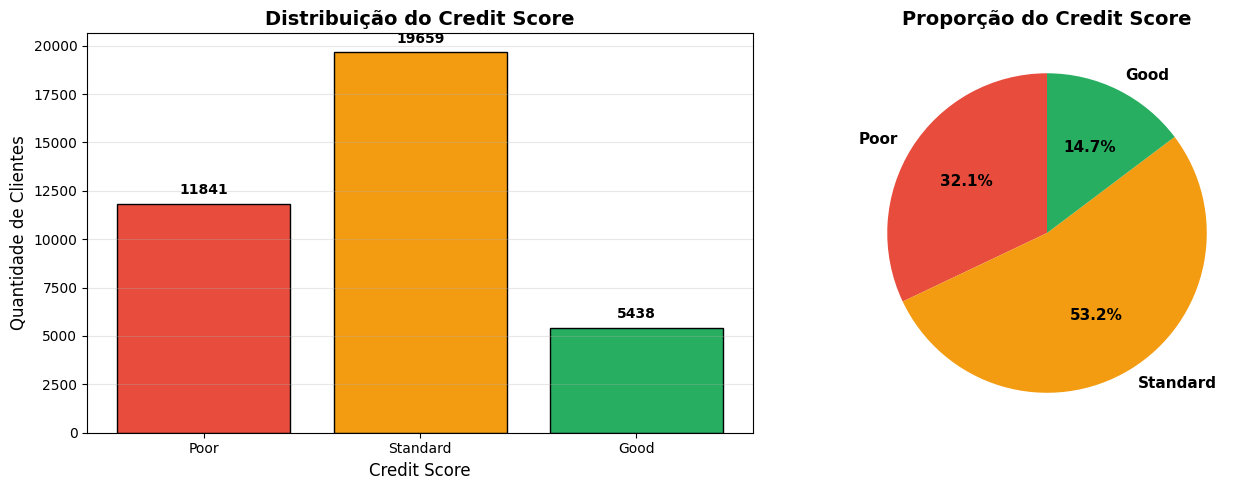

In [14]:
# Análise detalhada de valores ausentes
print("=" * 80)
print("ANÁLISE DE VALORES AUSENTES")
print("=" * 80)

missing_data = pd.DataFrame({
    'Coluna': df.columns,
    'Qtd_Missing': df.isnull().sum(),
    'Perc_Missing': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Qtd_Missing', ascending=False)

print("\nColunas com valores ausentes:")
display(missing_data[missing_data['Qtd_Missing'] > 0])

# Distribuição da variável target
print("\n" + "=" * 80)
print("DISTRIBUIÇÃO DO CREDIT SCORE (TARGET)")
print("=" * 80)

credit_score_dist = df['Credit_Score'].value_counts().sort_index()
credit_score_perc = (df['Credit_Score'].value_counts(normalize=True) * 100).round(2).sort_index()

score_summary = pd.DataFrame({
    'Classe': ['Poor', 'Standard', 'Good'],
    'Quantidade': credit_score_dist.values,
    'Percentual': credit_score_perc.values
})

display(score_summary)

# Visualização da distribuição do target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(score_summary['Classe'], score_summary['Quantidade'], color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='black')
axes[0].set_title('Distribuição do Credit Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Credit Score', fontsize=12)
axes[0].set_ylabel('Quantidade de Clientes', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(score_summary['Quantidade']):
    axes[0].text(i, v + 500, str(v), ha='center', fontweight='bold')

# Gráfico de pizza
colors_pie = ['#e74c3c', '#f39c12', '#27ae60']
axes[1].pie(score_summary['Quantidade'], labels=score_summary['Classe'], autopct='%1.1f%%', 
            colors=colors_pie, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Proporção do Credit Score', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


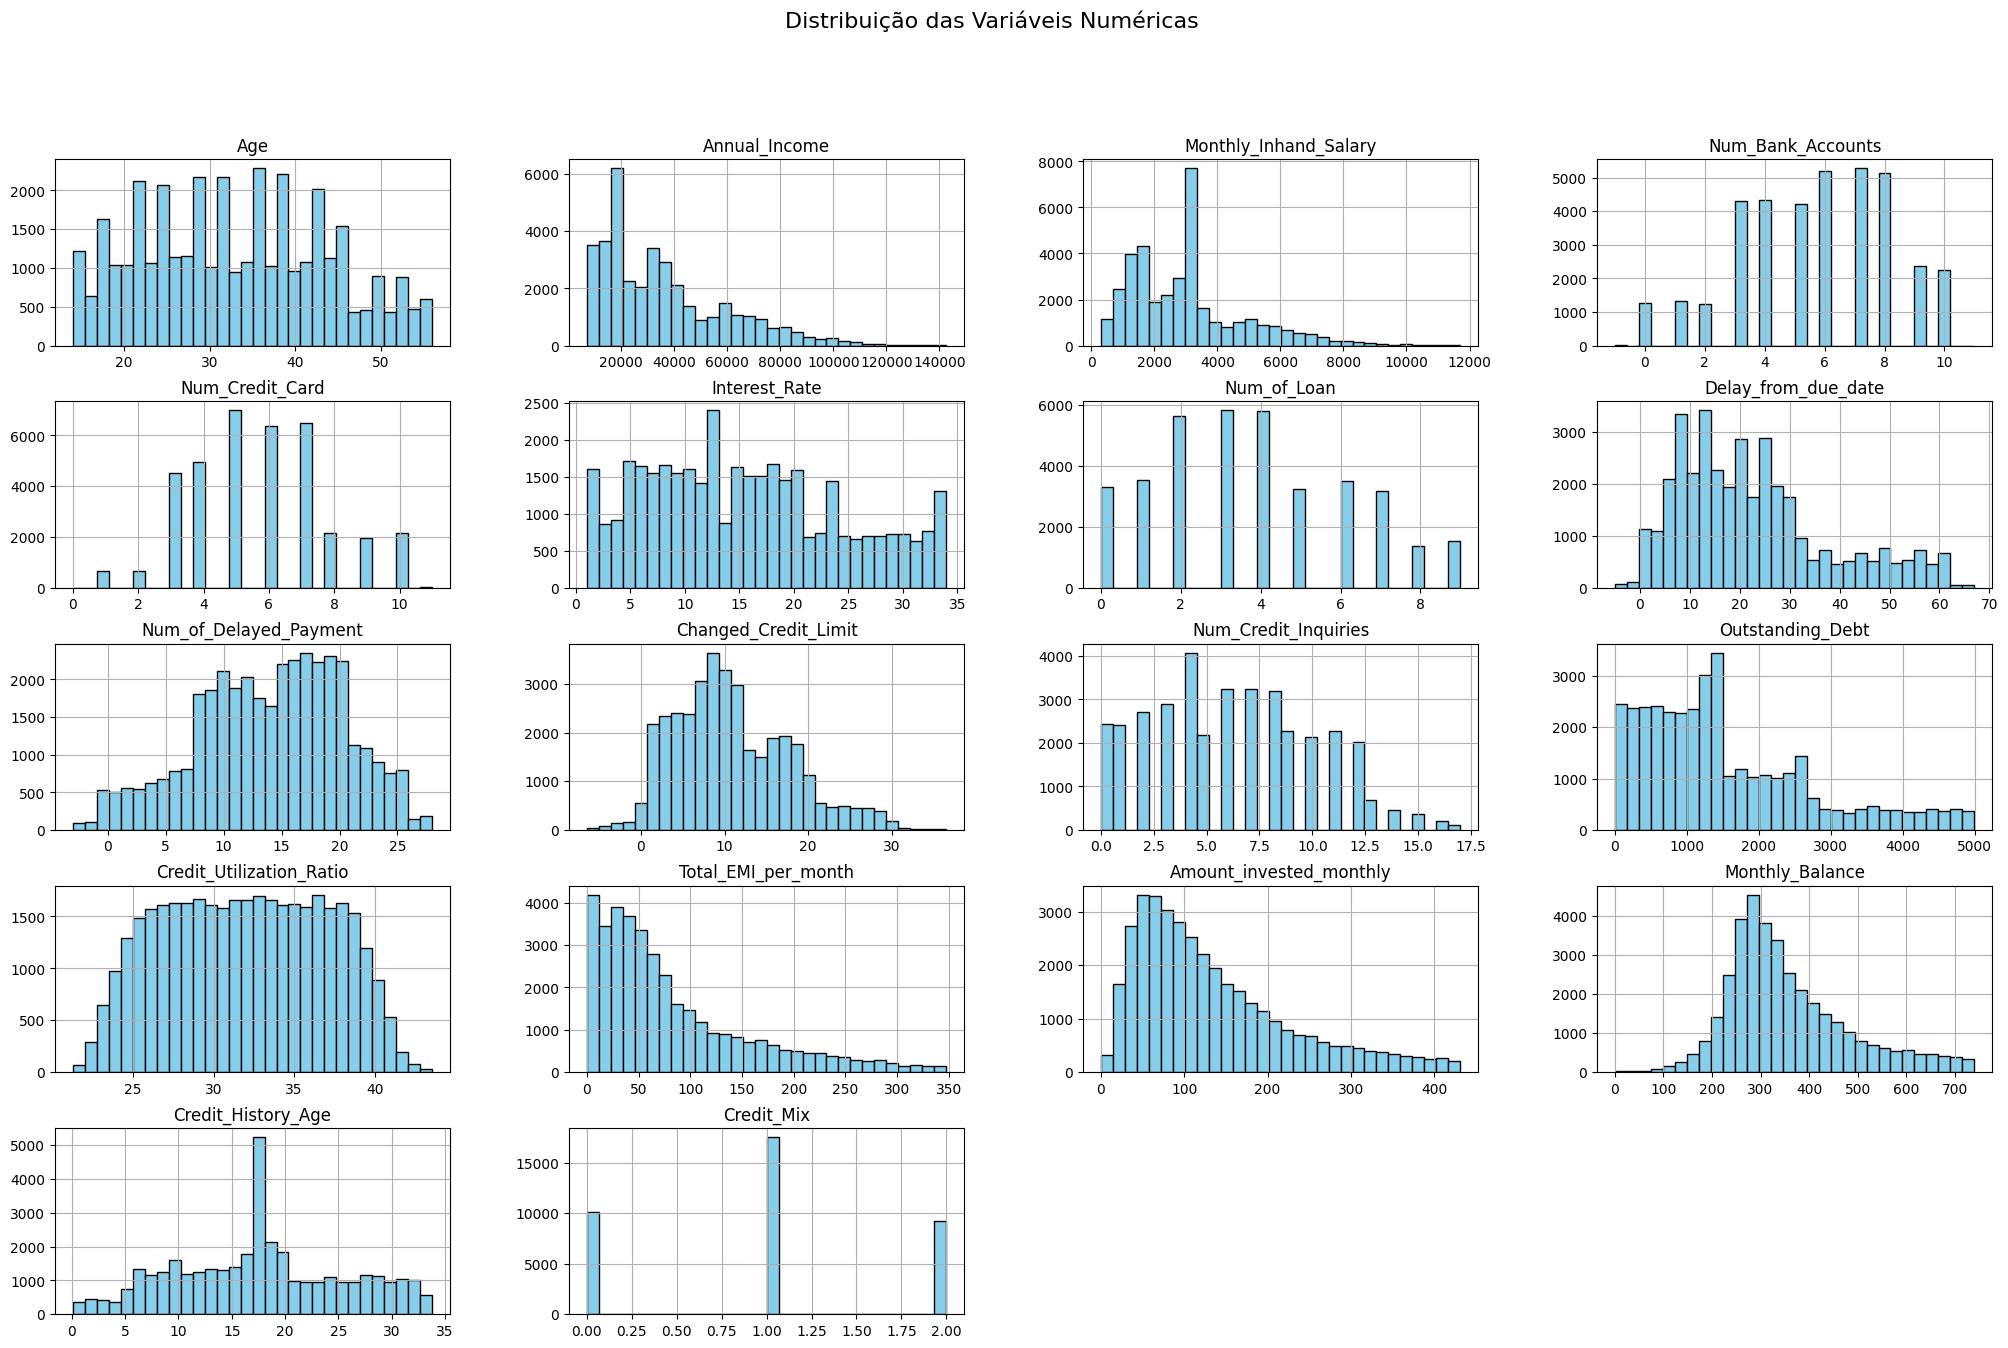

In [15]:
df[var_num].hist(bins=30, figsize=(25,15), color='skyblue', edgecolor='black')
plt.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)
plt.show()

### 📊 Análise Bivariada: Variáveis Numéricas vs Credit Score

Análise da relação entre as principais variáveis financeiras e o score de crédito.


In [16]:
# Análise das principais variáveis financeiras por Credit Score
print("=" * 80)
print("ANÁLISE BIVARIADA: VARIÁVEIS FINANCEIRAS vs CREDIT SCORE")
print("=" * 80)

# Variáveis chave para análise
key_vars = ['Annual_Income', 'Monthly_Inhand_Salary', 'Outstanding_Debt', 
            'Credit_Utilization_Ratio', 'Num_of_Delayed_Payment', 'Total_EMI_per_month']

# Mapeamento do Credit Score para rótulos legíveis
score_labels = {0: 'Poor', 1: 'Standard', 2: 'Good'}
df['Credit_Score_Label'] = df['Credit_Score'].map(score_labels)

# Estatísticas agregadas por Credit Score
for var in key_vars:
    print(f"\n{var} por Credit Score:")
    agg_stats = df.groupby('Credit_Score_Label')[var].agg(['mean', 'median', 'std']).round(2)
    display(agg_stats)
    print("-" * 80)


ANÁLISE BIVARIADA: VARIÁVEIS FINANCEIRAS vs CREDIT SCORE

Annual_Income por Credit Score:


,mean,median,std
Credit_Score_Label,,,
Good,40063.25,34132.87,23936.02
Poor,32404.74,22332.37,21594.51
Standard,37032.68,30815.44,24337.03


--------------------------------------------------------------------------------

Monthly_Inhand_Salary por Credit Score:


,mean,median,std
Credit_Score_Label,,,
Good,3294.33,2999.59,1864.57
Poor,2752.06,2769.52,1670.03
Standard,3067.15,2905.15,1872.14


--------------------------------------------------------------------------------

Outstanding_Debt por Credit Score:


,mean,median,std
Credit_Score_Label,,,
Good,813.63,737.37,649.28
Poor,2161.32,2032.49,1116.84
Standard,1356.18,1054.86,1178.48


--------------------------------------------------------------------------------

Credit_Utilization_Ratio por Credit Score:


,mean,median,std
Credit_Score_Label,,,
Good,32.21,32.25,5.01
Poor,31.81,31.86,5.00
Standard,32.03,32.01,4.97


--------------------------------------------------------------------------------

Num_of_Delayed_Payment por Credit Score:


,mean,median,std
Credit_Score_Label,,,
Good,8.92,9.0,5.69
Poor,16.31,17.0,5.84
Standard,13.96,14.0,5.58


--------------------------------------------------------------------------------

Total_EMI_per_month por Credit Score:


,mean,median,std
Credit_Score_Label,,,
Good,65.48,44.38,69.20
Poor,94.90,68.08,77.88
Standard,78.56,55.00,74.40


--------------------------------------------------------------------------------


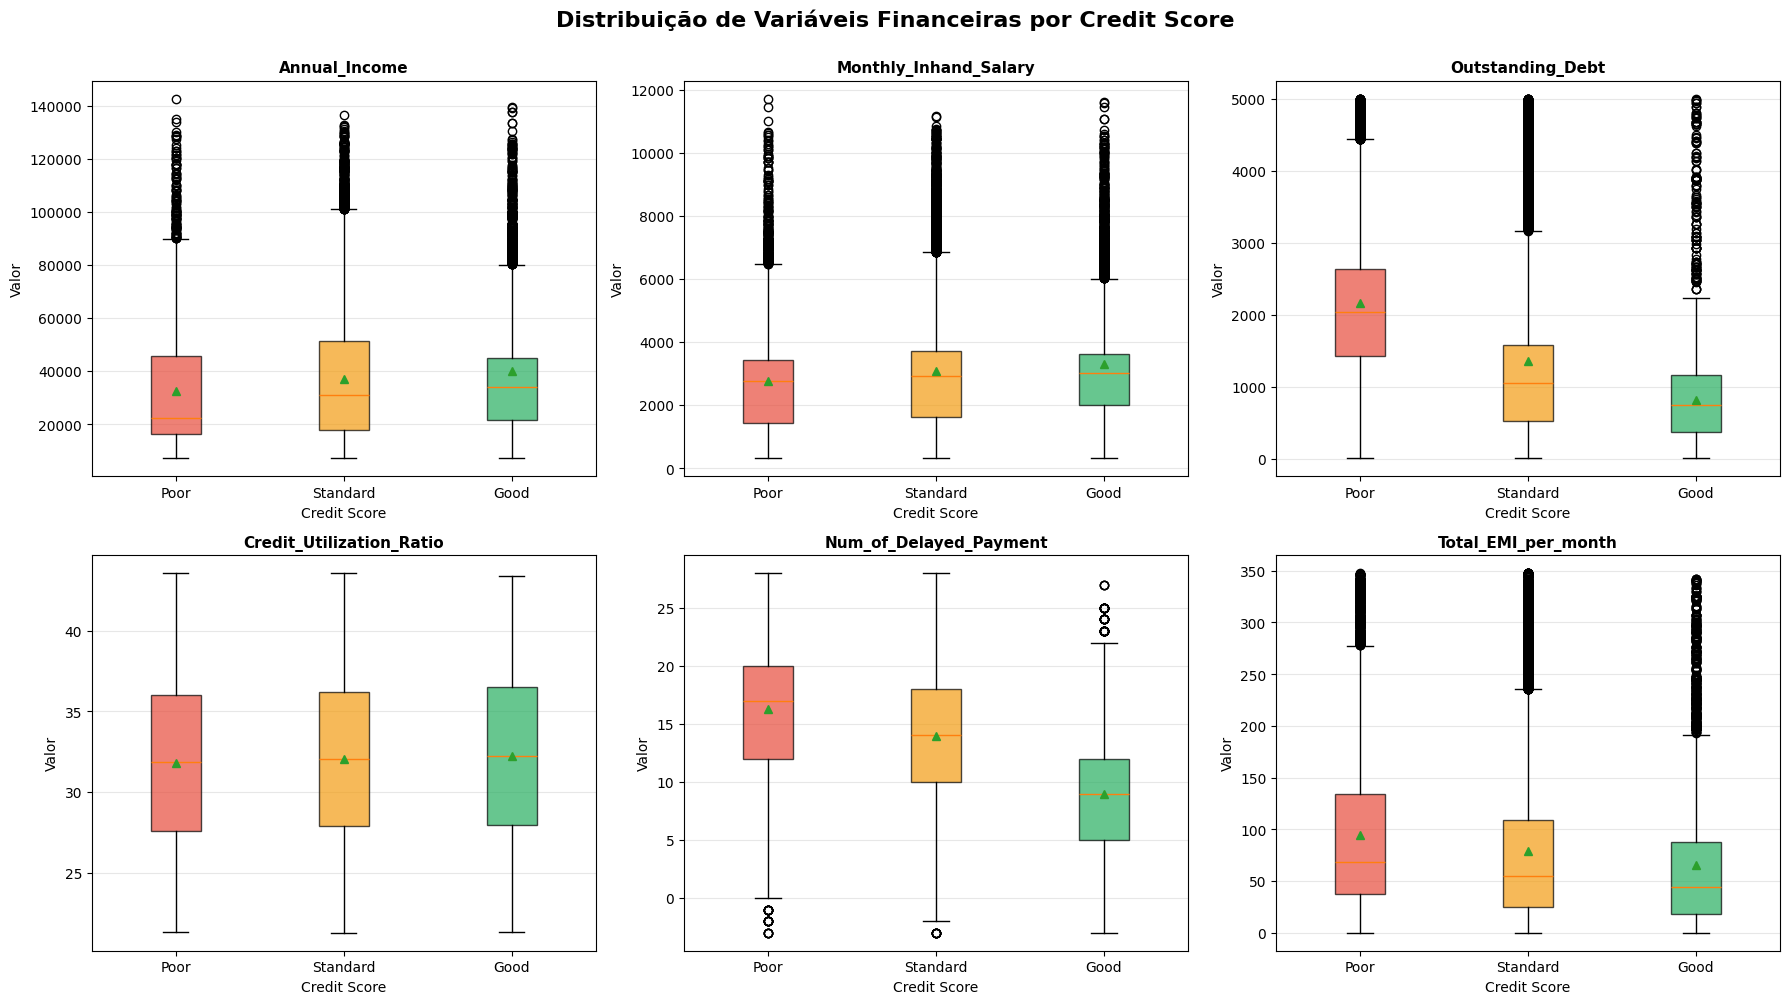

In [17]:
# Box plots das principais variáveis por Credit Score
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribuição de Variáveis Financeiras por Credit Score', 
             fontsize=16, fontweight='bold', y=1.00)

colors = ['#e74c3c', '#f39c12', '#27ae60']
axes_flat = axes.flatten()

for idx, var in enumerate(key_vars):
    ax = axes_flat[idx]
    
    # Criar box plot
    bp = ax.boxplot([df[df['Credit_Score_Label'] == 'Poor'][var].dropna(),
                      df[df['Credit_Score_Label'] == 'Standard'][var].dropna(),
                      df[df['Credit_Score_Label'] == 'Good'][var].dropna()],
                     labels=['Poor', 'Standard', 'Good'],
                     patch_artist=True,
                     showmeans=True)
    
    # Colorir boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(var, fontsize=11, fontweight='bold')
    ax.set_xlabel('Credit Score', fontsize=10)
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


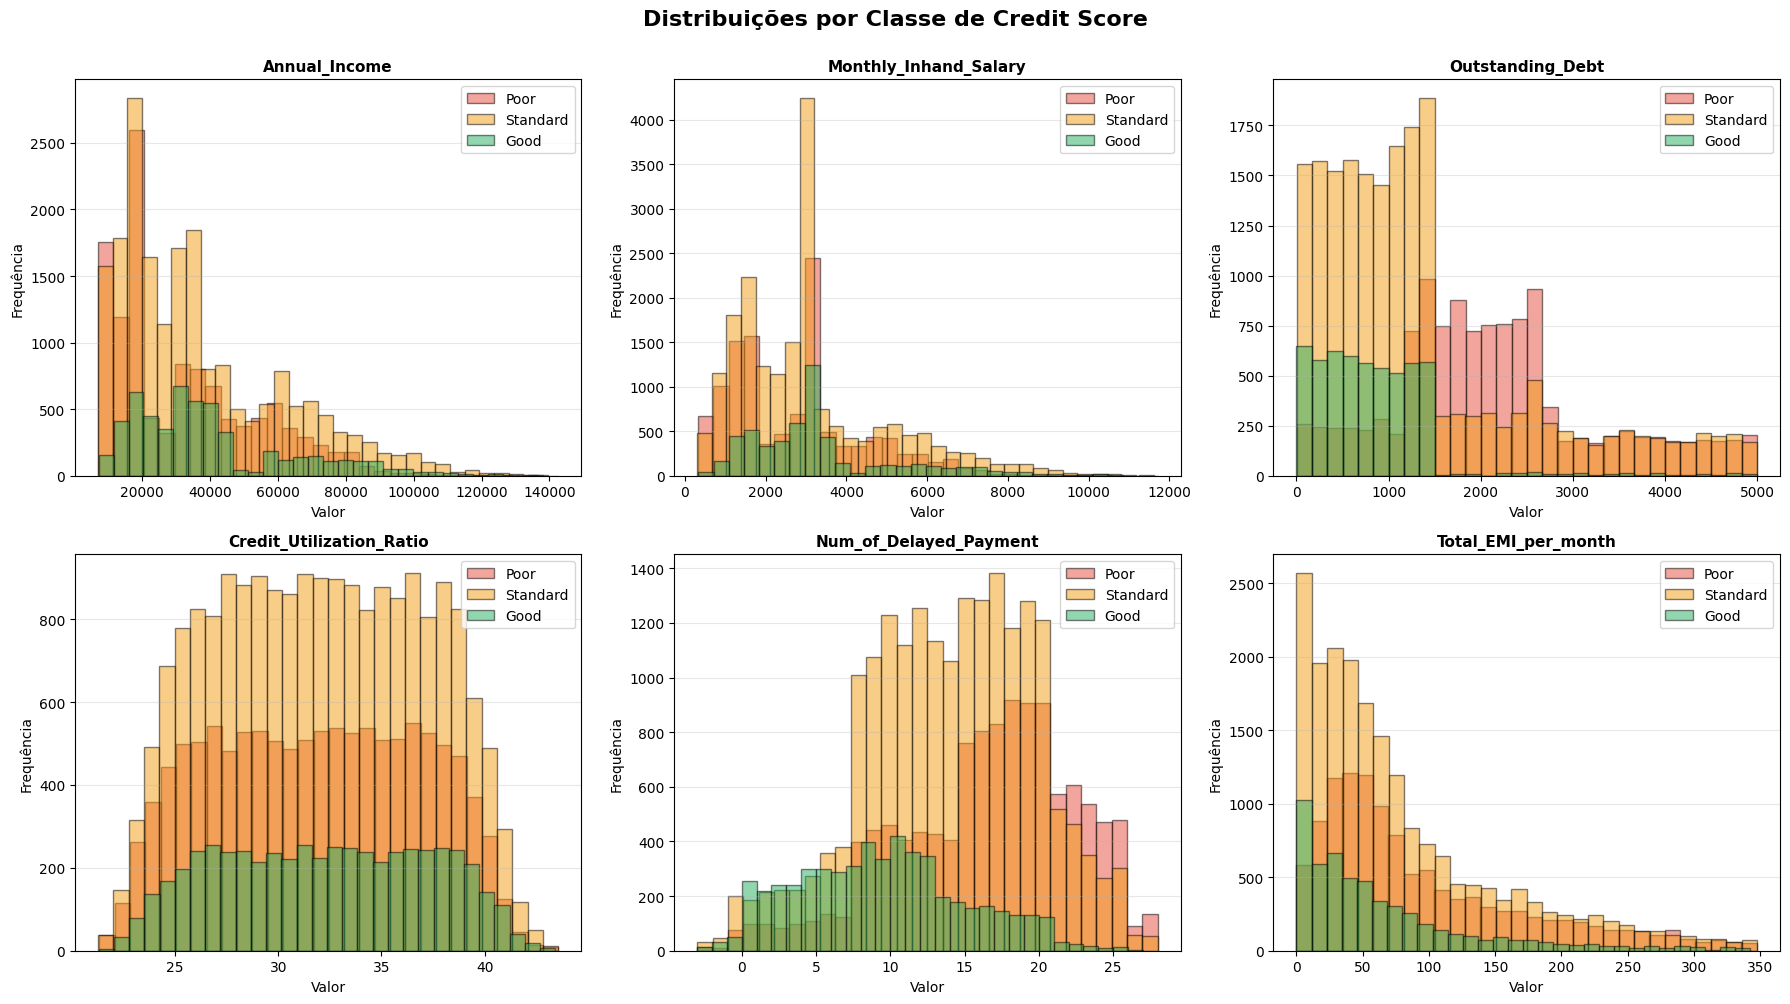

In [18]:
# Distribuições sobrepostas por Credit Score
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribuições por Classe de Credit Score', 
             fontsize=16, fontweight='bold', y=1.00)

axes_flat = axes.flatten()
colors_hist = {'Poor': '#e74c3c', 'Standard': '#f39c12', 'Good': '#27ae60'}

for idx, var in enumerate(key_vars):
    ax = axes_flat[idx]
    
    for score in ['Poor', 'Standard', 'Good']:
        data = df[df['Credit_Score_Label'] == score][var].dropna()
        ax.hist(data, bins=30, alpha=0.5, label=score, color=colors_hist[score], edgecolor='black')
    
    ax.set_title(var, fontsize=11, fontweight='bold')
    ax.set_xlabel('Valor', fontsize=10)
    ax.set_ylabel('Frequência', fontsize=10)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 🔍 Análise de Correlações e Padrões Financeiros

Identificação das variáveis mais correlacionadas com o Credit Score e padrões de comportamento.


CORRELAÇÃO DAS VARIÁVEIS COM CREDIT SCORE

Top 10 variáveis mais correlacionadas (positivamente):


Credit_Score                1.000
Credit_Mix                  0.506
Credit_History_Age          0.379
Monthly_Balance             0.199
Age                         0.163
Annual_Income               0.112
Monthly_Inhand_Salary       0.102
Amount_invested_monthly     0.062
Credit_Utilization_Ratio    0.027
Total_EMI_per_month        -0.132
Changed_Credit_Limit       -0.155
Name: Credit_Score, dtype: float64


Top 10 variáveis mais correlacionadas (negativamente):


Total_EMI_per_month      -0.132
Changed_Credit_Limit     -0.155
Num_of_Loan              -0.354
Num_of_Delayed_Payment   -0.367
Outstanding_Debt         -0.389
Num_Bank_Accounts        -0.390
Num_Credit_Card          -0.399
Delay_from_due_date      -0.424
Num_Credit_Inquiries     -0.454
Interest_Rate            -0.496
Name: Credit_Score, dtype: float64

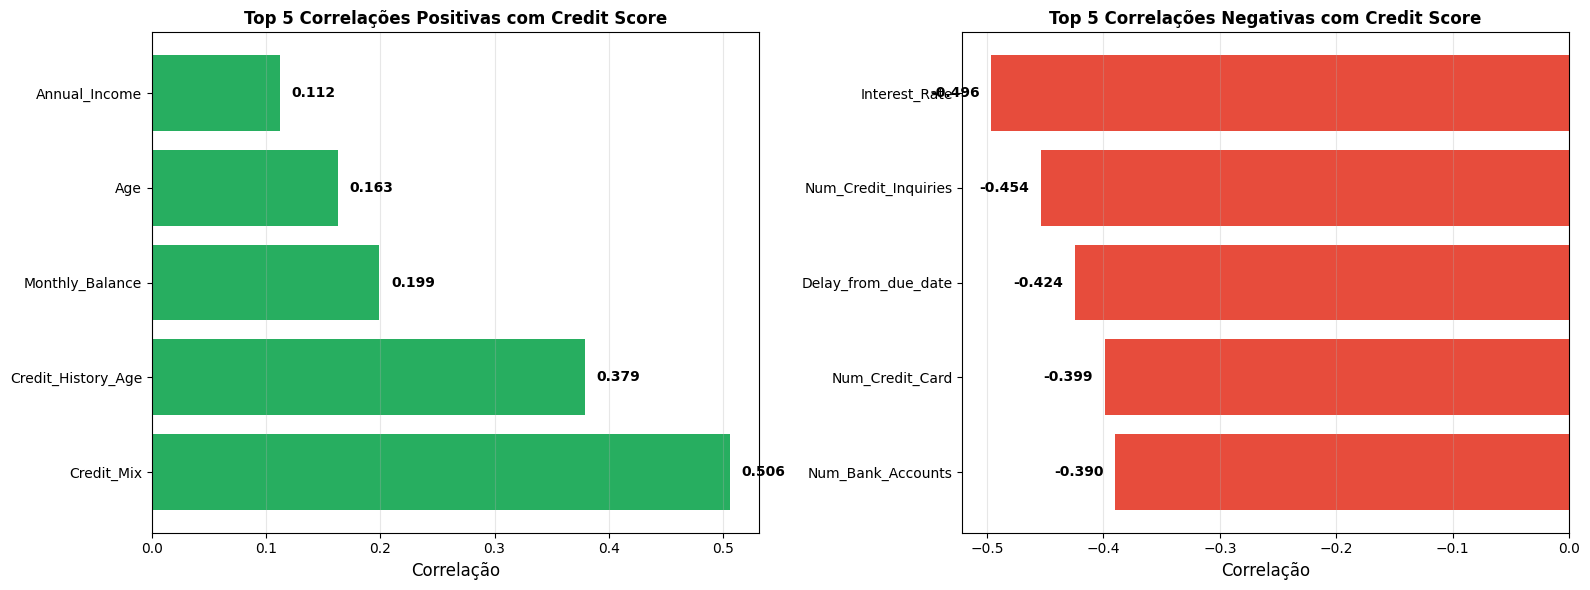

In [19]:
# Correlação das variáveis com Credit Score
print("=" * 80)
print("CORRELAÇÃO DAS VARIÁVEIS COM CREDIT SCORE")
print("=" * 80)

correlations = df[var_num + ['Credit_Score']].corr()['Credit_Score'].sort_values(ascending=False)
print("\nTop 10 variáveis mais correlacionadas (positivamente):")
display(correlations.head(11).round(3))  # 11 para incluir o próprio Credit_Score

print("\nTop 10 variáveis mais correlacionadas (negativamente):")
display(correlations.tail(10).round(3))

# Visualização das top correlações
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlações positivas
top_positive = correlations.head(6)[1:]  # Excluindo o próprio Credit_Score
axes[0].barh(range(len(top_positive)), top_positive.values, color='#27ae60')
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(top_positive.index)
axes[0].set_xlabel('Correlação', fontsize=12)
axes[0].set_title('Top 5 Correlações Positivas com Credit Score', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(top_positive.values):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

# Correlações negativas
top_negative = correlations.tail(5)
axes[1].barh(range(len(top_negative)), top_negative.values, color='#e74c3c')
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(top_negative.index)
axes[1].set_xlabel('Correlação', fontsize=12)
axes[1].set_title('Top 5 Correlações Negativas com Credit Score', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(top_negative.values):
    axes[1].text(v - 0.01, i, f'{v:.3f}', va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()


ANÁLISE DE COMPORTAMENTO FINANCEIRO POR CREDIT SCORE

1. MÉDIA DE PAGAMENTOS ATRASADOS POR CATEGORIA:


,mean,median,max
Credit_Score_Label,,,
Good,8.92,9.0,27.0
Poor,16.31,17.0,28.0
Standard,13.96,14.0,28.0



2. UTILIZAÇÃO DE CRÉDITO POR CATEGORIA:


,mean,median,std
Credit_Score_Label,,,
Good,32.21,32.25,5.01
Poor,31.81,31.86,5.00
Standard,32.03,32.01,4.97



3. HISTÓRICO DE CRÉDITO (em anos) POR CATEGORIA:


,mean,median,min,max
Credit_Score_Label,,,,
Good,23.07,23.10,0.6,33.8
Poor,13.88,13.70,0.1,33.8
Standard,18.28,17.57,0.1,33.8


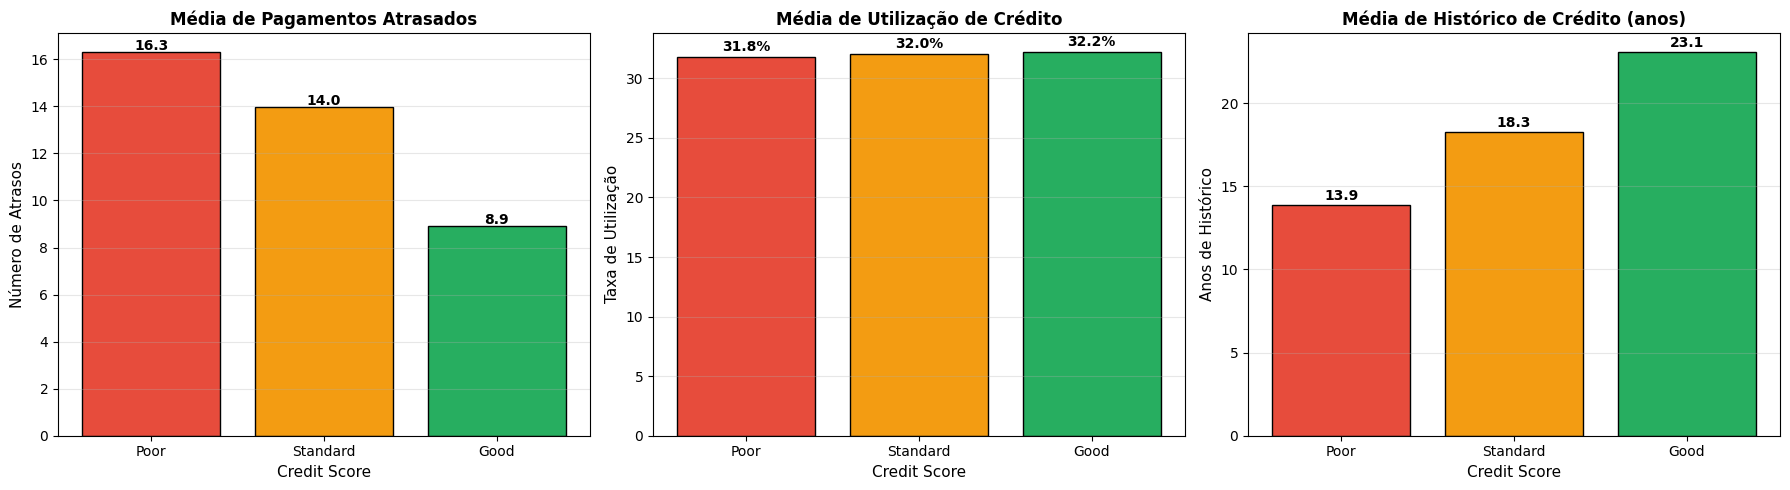

In [20]:
# Análise de comportamento de pagamento
print("=" * 80)
print("ANÁLISE DE COMPORTAMENTO FINANCEIRO POR CREDIT SCORE")
print("=" * 80)

# Análise de atrasos de pagamento
print("\n1. MÉDIA DE PAGAMENTOS ATRASADOS POR CATEGORIA:")
delay_analysis = df.groupby('Credit_Score_Label')['Num_of_Delayed_Payment'].agg(['mean', 'median', 'max']).round(2)
display(delay_analysis)

# Análise de utilização de crédito
print("\n2. UTILIZAÇÃO DE CRÉDITO POR CATEGORIA:")
credit_util = df.groupby('Credit_Score_Label')['Credit_Utilization_Ratio'].agg(['mean', 'median', 'std']).round(2)
display(credit_util)

# Análise de histórico de crédito
print("\n3. HISTÓRICO DE CRÉDITO (em anos) POR CATEGORIA:")
credit_hist = df.groupby('Credit_Score_Label')['Credit_History_Age'].agg(['mean', 'median', 'min', 'max']).round(2)
display(credit_hist)

# Visualização comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Pagamentos Atrasados
delay_means = df.groupby('Credit_Score_Label')['Num_of_Delayed_Payment'].mean().reindex(['Poor', 'Standard', 'Good'])
axes[0].bar(delay_means.index, delay_means.values, color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='black')
axes[0].set_title('Média de Pagamentos Atrasados', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Credit Score', fontsize=11)
axes[0].set_ylabel('Número de Atrasos', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(delay_means.values):
    axes[0].text(i, v + 0.1, f'{v:.1f}', ha='center', fontweight='bold')

# Gráfico 2: Utilização de Crédito
util_means = df.groupby('Credit_Score_Label')['Credit_Utilization_Ratio'].mean().reindex(['Poor', 'Standard', 'Good'])
axes[1].bar(util_means.index, util_means.values, color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='black')
axes[1].set_title('Média de Utilização de Crédito', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Credit Score', fontsize=11)
axes[1].set_ylabel('Taxa de Utilização', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(util_means.values):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# Gráfico 3: Histórico de Crédito
hist_means = df.groupby('Credit_Score_Label')['Credit_History_Age'].mean().reindex(['Poor', 'Standard', 'Good'])
axes[2].bar(hist_means.index, hist_means.values, color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='black')
axes[2].set_title('Média de Histórico de Crédito (anos)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Credit Score', fontsize=11)
axes[2].set_ylabel('Anos de Histórico', fontsize=11)
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(hist_means.values):
    axes[2].text(i, v + 0.3, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


### 💡 Insights de Negócio e Perfis de Risco

Extração de padrões comportamentais e recomendações para a Quantum Finance.


In [21]:
print("=" * 80)
print("INSIGHTS DE NEGÓCIO - PERFIS DE RISCO")
print("=" * 80)

# Criação de perfis consolidados
profile_summary = pd.DataFrame({
    'Métrica': [
        'Renda Anual Média (R$)',
        'Salário Mensal Médio (R$)',
        'Dívida Pendente Média (R$)',
        'Utilização Crédito (%)',
        'Pagamentos Atrasados',
        'Consultas de Crédito',
        'Histórico Crédito (anos)',
        'EMI Total Mensal (R$)'
    ],
    'Poor': [
        df[df['Credit_Score_Label'] == 'Poor']['Annual_Income'].mean(),
        df[df['Credit_Score_Label'] == 'Poor']['Monthly_Inhand_Salary'].mean(),
        df[df['Credit_Score_Label'] == 'Poor']['Outstanding_Debt'].mean(),
        df[df['Credit_Score_Label'] == 'Poor']['Credit_Utilization_Ratio'].mean(),
        df[df['Credit_Score_Label'] == 'Poor']['Num_of_Delayed_Payment'].mean(),
        df[df['Credit_Score_Label'] == 'Poor']['Num_Credit_Inquiries'].mean(),
        df[df['Credit_Score_Label'] == 'Poor']['Credit_History_Age'].mean(),
        df[df['Credit_Score_Label'] == 'Poor']['Total_EMI_per_month'].mean()
    ],
    'Standard': [
        df[df['Credit_Score_Label'] == 'Standard']['Annual_Income'].mean(),
        df[df['Credit_Score_Label'] == 'Standard']['Monthly_Inhand_Salary'].mean(),
        df[df['Credit_Score_Label'] == 'Standard']['Outstanding_Debt'].mean(),
        df[df['Credit_Score_Label'] == 'Standard']['Credit_Utilization_Ratio'].mean(),
        df[df['Credit_Score_Label'] == 'Standard']['Num_of_Delayed_Payment'].mean(),
        df[df['Credit_Score_Label'] == 'Standard']['Num_Credit_Inquiries'].mean(),
        df[df['Credit_Score_Label'] == 'Standard']['Credit_History_Age'].mean(),
        df[df['Credit_Score_Label'] == 'Standard']['Total_EMI_per_month'].mean()
    ],
    'Good': [
        df[df['Credit_Score_Label'] == 'Good']['Annual_Income'].mean(),
        df[df['Credit_Score_Label'] == 'Good']['Monthly_Inhand_Salary'].mean(),
        df[df['Credit_Score_Label'] == 'Good']['Outstanding_Debt'].mean(),
        df[df['Credit_Score_Label'] == 'Good']['Credit_Utilization_Ratio'].mean(),
        df[df['Credit_Score_Label'] == 'Good']['Num_of_Delayed_Payment'].mean(),
        df[df['Credit_Score_Label'] == 'Good']['Num_Credit_Inquiries'].mean(),
        df[df['Credit_Score_Label'] == 'Good']['Credit_History_Age'].mean(),
        df[df['Credit_Score_Label'] == 'Good']['Total_EMI_per_month'].mean()
    ]
})

# Arredondar valores
profile_summary['Poor'] = profile_summary['Poor'].round(2)
profile_summary['Standard'] = profile_summary['Standard'].round(2)
profile_summary['Good'] = profile_summary['Good'].round(2)

print("\nPERFIL FINANCEIRO CONSOLIDADO POR CATEGORIA DE CRÉDITO:")
print("=" * 80)
display(profile_summary)

# Calcular diferenças percentuais entre Poor e Good
print("\n" + "=" * 80)
print("DIFERENÇAS ENTRE PERFIS 'POOR' vs 'GOOD':")
print("=" * 80)

differences = pd.DataFrame({
    'Métrica': profile_summary['Métrica'],
    'Diferença (%)': ((profile_summary['Good'] - profile_summary['Poor']) / profile_summary['Poor'] * 100).round(2)
})

display(differences)


INSIGHTS DE NEGÓCIO - PERFIS DE RISCO

PERFIL FINANCEIRO CONSOLIDADO POR CATEGORIA DE CRÉDITO:


,Métrica,Poor,Standard,Good
0,Renda Anual Média (R$),32404.74,37032.68,40063.25
1,Salário Mensal Médio (R$),2752.06,3067.15,3294.33
2,Dívida Pendente Média (R$),2161.32,1356.18,813.63
3,Utilização Crédito (%),31.81,32.03,32.21
4,Pagamentos Atrasados,16.31,13.96,8.92
5,Consultas de Crédito,8.54,5.57,3.34
6,Histórico Crédito (anos),13.88,18.28,23.07
7,EMI Total Mensal (R$),94.90,78.56,65.48



DIFERENÇAS ENTRE PERFIS 'POOR' vs 'GOOD':


,Métrica,Diferença (%)
0,Renda Anual Média (R$),23.63
1,Salário Mensal Médio (R$),19.70
2,Dívida Pendente Média (R$),-62.35
3,Utilização Crédito (%),1.26
4,Pagamentos Atrasados,-45.31
5,Consultas de Crédito,-60.89
6,Histórico Crédito (anos),66.21
7,EMI Total Mensal (R$),-31.00


### 📋 Conclusões da Análise Exploratória

#### 🎯 Principais Descobertas:

**1. Distribuição do Target:**
- A base possui uma distribuição relativamente balanceada entre as três classes de Credit Score
- Isso facilita o treinamento de modelos de classificação sem necessidade de balanceamento artificial

**2. Padrões Financeiros Identificados:**

**Clientes "POOR" (Alto Risco):**
- ❌ Maior número de pagamentos atrasados
- ❌ Alta utilização de crédito (próxima ao limite)
- ❌ Menor histórico de crédito
- ❌ Mais consultas de crédito recentes (indicativo de necessidade de crédito)

**Clientes "GOOD" (Baixo Risco):**
- ✅ Poucos ou nenhum pagamento atrasado
- ✅ Utilização de crédito moderada e controlada
- ✅ Histórico de crédito mais longo e estabelecido
- ✅ Comportamento financeiro estável

**3. Variáveis Mais Importantes:**
- **Num_of_Delayed_Payment**: Forte correlação negativa com bom score
- **Credit_Utilization_Ratio**: Utilização alta indica maior risco
- **Credit_History_Age**: Histórico mais longo associado a melhor score
- **Outstanding_Debt**: Dívida pendente impacta negativamente
- **Payment_Behaviour**: Padrão de pagamento é crucial

#### 💼 Recomendações para a Quantum Finance:

**1. Critérios de Aprovação Automática:**
- Clientes "Good": Aprovação imediata com limites maiores
- Clientes "Standard": Aprovação padrão com monitoramento
- Clientes "Poor": Análise manual ou aprovação com limite reduzido

**2. Estratégias de Precificação:**
- Ajustar taxas de juros baseado no perfil de risco
- Oferecer condições especiais para clientes "Good" (fidelização)

**3. Monitoramento Contínuo:**
- Acompanhar mudanças no comportamento de pagamento
- Alertas automáticos para deterioração de score
- Programas de recuperação para clientes em risco

**4. Oportunidades de Cross-sell:**
- Clientes "Good": Produtos premium, cartões platinum, investimentos
- Clientes "Standard": Produtos de educação financeira e upgrade
- Clientes "Poor": Produtos de reconstrução de crédito

---

**Próximas Etapas:** Desenvolvimento e comparação dos modelos de Machine Learning (Random Forest, XGBoost, LightGBM)


---

### 📊 Resumo das Análises Implementadas na EDA

Esta seção de Análise Exploratória foi expandida com as seguintes análises aprofundadas:

✅ **Análise de Valores Ausentes**: Identificação detalhada de missing values por coluna

✅ **Distribuição do Target**: Visualização da proporção de classes (Poor/Standard/Good)

✅ **Análise Bivariada**: Comparação de variáveis financeiras por categoria de Credit Score

✅ **Visualizações Profissionais**: Box plots e distribuições sobrepostas por classe

✅ **Correlações com Target**: Identificação das variáveis mais importantes

✅ **Padrões Financeiros**: Análise de comportamento de pagamento e utilização de crédito

✅ **Perfis de Risco**: Caracterização detalhada de cada categoria de cliente

✅ **Insights de Negócio**: Recomendações práticas para a Quantum Finance

**Total de variáveis analisadas**: 18 features numéricas + 1 target (Credit_Score)

---


Exibindo a matriz de correlação.

In [22]:
print("\nMatriz de correlação:")
corr = df.corr(numeric_only=True)
display(corr)


Matriz de correlação:


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score
Age,1.000000,0.054531,0.047084,-0.195050,-0.148584,-0.217974,-0.205653,-0.174220,-0.185342,-0.152876,-0.246758,0.247915,-0.201438,0.012754,0.224700,-0.160495,-0.096559,0.028618,0.116606,0.162520
Annual_Income,0.054531,1.000000,0.919115,-0.154223,-0.131049,-0.179431,-0.139391,-0.139692,-0.148667,-0.102622,-0.167860,0.189691,-0.184500,0.098313,0.168282,-0.096717,0.597468,0.543391,0.724140,0.112151
Monthly_Inhand_Salary,0.047084,0.919115,1.000000,-0.142277,-0.120568,-0.166807,-0.127486,-0.129533,-0.138266,-0.096633,-0.155858,0.175483,-0.169862,0.090652,0.156652,-0.093021,0.545380,0.504377,0.673554,0.102035
Num_Bank_Accounts,-0.195050,-0.154223,-0.142277,1.000000,0.437790,0.570780,0.467327,0.551269,0.581020,0.308894,0.519621,-0.713351,0.510334,-0.030852,-0.458526,0.343025,0.178453,-0.113374,-0.254589,-0.389712
Num_Credit_Card,-0.148584,-0.131049,-0.120568,0.437790,1.000000,0.495437,0.408574,0.477597,0.413371,0.240758,0.464495,-0.541666,0.485936,-0.026389,-0.398652,0.244664,0.160376,-0.092343,-0.222880,-0.398765
Interest_Rate,-0.217974,-0.179431,-0.166807,0.570780,0.495437,1.000000,0.543938,0.574415,0.552168,0.350194,0.632537,-0.736809,0.623781,-0.035221,-0.548004,0.371455,0.206730,-0.129674,-0.296322,-0.496386
Num_of_Loan,-0.205653,-0.139391,-0.127486,0.467327,0.408574,0.543938,1.000000,0.490026,0.468614,0.357690,0.549338,-0.633655,0.637617,-0.048269,-0.572515,0.303261,0.514733,-0.119214,-0.431669,-0.354097
Delay_from_due_date,-0.174220,-0.139692,-0.129533,0.551269,0.477597,0.574415,0.490026,1.000000,0.526931,0.271076,0.535803,-0.679857,0.563667,-0.032944,-0.462333,0.295651,0.207914,-0.100908,-0.259082,-0.424261
Num_of_Delayed_Payment,-0.185342,-0.148667,-0.138266,0.581020,0.413371,0.552168,0.468614,0.526931,1.000000,0.295715,0.492655,-0.745234,0.506507,-0.030877,-0.457722,0.340172,0.188952,-0.106657,-0.255065,-0.367289
Changed_Credit_Limit,-0.152876,-0.102622,-0.096633,0.308894,0.240758,0.350194,0.357690,0.271076,0.295715,1.000000,0.357914,-0.399632,0.461172,-0.018129,-0.401212,0.290197,0.145213,-0.080698,-0.183249,-0.154605


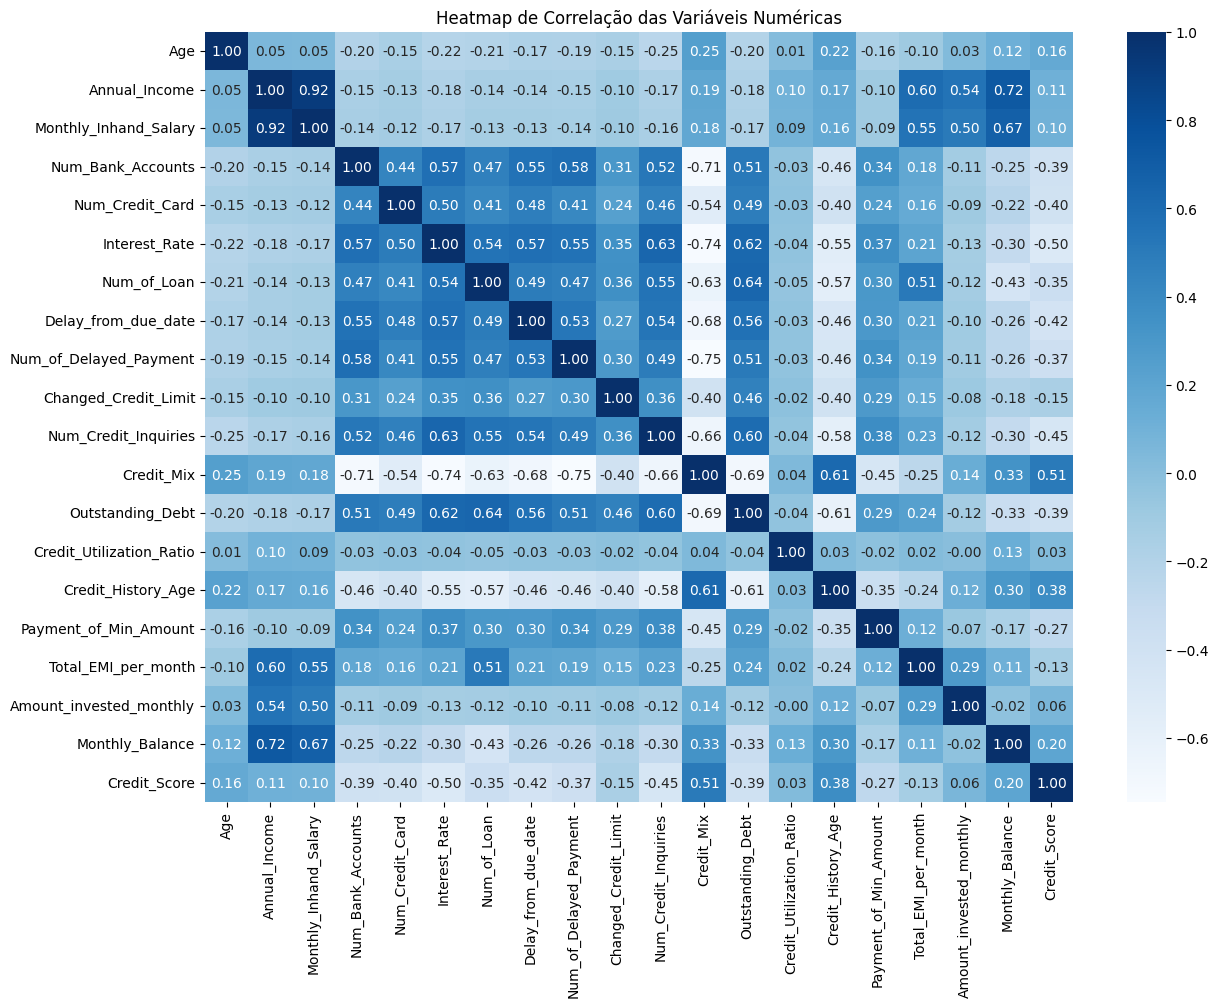

In [23]:
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Heatmap de Correlação das Variáveis Numéricas')
plt.show()


<i><p style='color:#006DB2' ><big><strong>10.</strong></big>Modelos de Classificação </p>
<br>
<p style='color:#006DB2' ><big><strong>Random Forest</strong></big></p>


<p style='color:#006DB2' ><li style='color:#006DB2' >Cria pipeline com StandardScaler e RandomForestClassifier.</li>
<li style='color:#006DB2' >Usa GridSearchCV para otimizar hiperparâmetros.</li>
<li style='color:#006DB2' >Exibe melhor score e parâmetros</li></p></i>
<br>

<p style='color:#006DB2' ><big><strong>LightGBM</strong></big></p>

<p style='color:#006DB2' ><li style='color:#006DB2' >Prepara dados e aplica StandardScaler.</li>
<li style='color:#006DB2' >Treina LGBMClassifier com GridSearchCV.</li>
<li style='color:#006DB2' >Exibe melhor score e parâmetros.</li></p></i>
<br>

<p style='color:#006DB2' ><big><strong>XGBoost</strong></big></p>

<p style='color:#006DB2' ><li style='color:#006DB2' >Prepara dados e aplica StandardScaler.</li>
<li style='color:#006DB2' >Treina XGBClassifier com GridSearchCV.</li>
<li style='color:#006DB2' >Exibe melhor score e parâmetros.</li></p></i>

In [19]:
X = df[var_num].fillna(df[var_num].mean())
y = df['Credit_Score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [5, 10, None]
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Melhor score:", grid.best_score_)
print("Melhores parâmetros:", grid.best_params_)

Melhor score: 0.7720135363790187
Melhores parâmetros: {'rf__max_depth': None, 'rf__n_estimators': 200}


In [20]:

X_lgbm = df[var_num].fillna(df[var_num].mean())
y_lgbm = df['Credit_Score']

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_lgbm, y_lgbm, test_size=0.2, random_state=42)

scaler_lgbm = StandardScaler()
X_train_lgbm_scaled = scaler_lgbm.fit_transform(X_train_lgbm)
X_test_lgbm_scaled = scaler_lgbm.transform(X_test_lgbm)

lgbm_model = LGBMClassifier(random_state=42)
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, -1]
}

grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, cv=3, scoring='accuracy')
grid_lgbm.fit(X_train_lgbm_scaled, y_train_lgbm)

print("Melhor score LightGBM:", grid_lgbm.best_score_)
print("Melhores parâmetros LightGBM:", grid_lgbm.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 19700, number of used features: 18
[LightGBM] [Info] Start training from score -1,138483
[LightGBM] [Info] Start training from score -0,634017
[LightGBM] [Info] Start training from score -1,902209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [21]:
X_xgb = df[var_num].fillna(df[var_num].mean())
y_xgb = df['Credit_Score']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

scaler_xgb = StandardScaler()
X_train_xgb_scaled = scaler_xgb.fit_transform(X_train_xgb)
X_test_xgb_scaled = scaler_xgb.transform(X_test_xgb)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy')
grid_xgb.fit(X_train_xgb_scaled, y_train_xgb)

print("Melhor score XGBoost:", grid_xgb.best_score_)
print("Melhores parâmetros XGBoost:", grid_xgb.best_params_)


Melhor score XGBoost: 0.7566835871404399
Melhores parâmetros XGBoost: {'max_depth': 10, 'n_estimators': 100}
